In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm import tqdm

# !pip install -q segmentation-models-pytorch
# !pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
!pwd

/media/karthikragunath/Personal-Data/Aerial-Semantic-Segmentation


In [3]:
IMAGE_PATH = 'dataset/semantic_drone_dataset/original_images/'
MASK_PATH = 'dataset/semantic_drone_dataset/label_images_semantic/'

In [4]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [5]:
df

,id
0,000
1,001
2,002
3,003
4,004
...,...
395,592
396,593
397,594
398,596


In [6]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

In [7]:
print(len(X_train), len(X_val), len(X_test))

306 54 40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


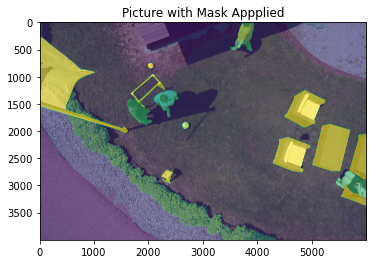

In [8]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

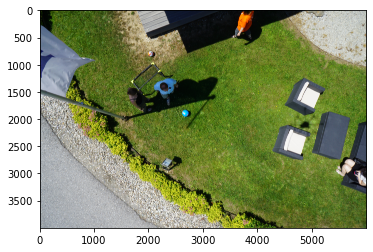

In [9]:
plt.imshow(img)

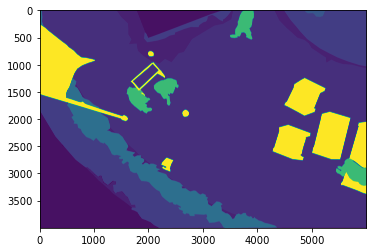

In [10]:
plt.imshow(mask)

In [8]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

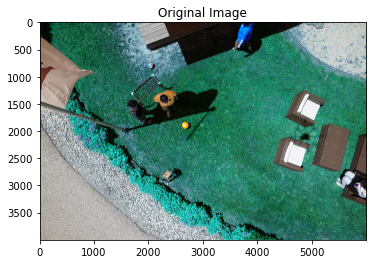

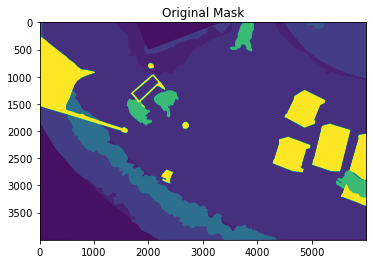

Original Img Shape: (4000, 6000, 3)
Original Mask Shape: (4000, 6000)
Augmentation Applied
1. Augmented Img Shape: (704, 1056, 3)
1. Augmented Mask Shape: (704, 1056)


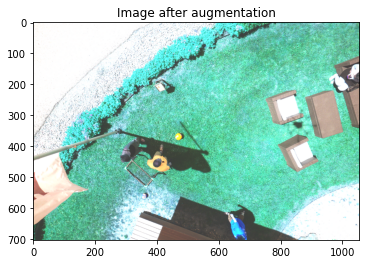

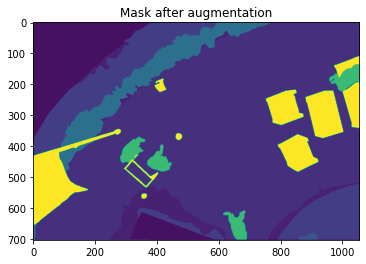

1. Augmented-Tensor Img Shape: (3, 704, 1056)
2. Img Shape after unfolding: (3, 1, 1056, 512)
----------------------
3. Img Shape after unfolding again: (3, 1, 1, 512, 768)
----------------------
4. Img Shape after changing mem layout: (3, 1, 512, 768)
----------------------
5. Img Shape after permutting: (1, 3, 512, 768)
----------------------
6. Augmented-Tensor Mask Shape: (704, 1056)
7. Mask Shape after unfolding: (1, 1056, 512)
----------------------
8. Mask Shape after unfolding again: (1, 1, 512, 768)
----------------------
9. Mask Shape after changing mem layout: (1, 512, 768)


In [25]:
# Understanding Code

img = cv2.imread(IMAGE_PATH + df['id'][100] + '.jpg', cv2.COLOR_BGR2RGB)
mask = cv2.imread(MASK_PATH + df['id'][100] + '.png', cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Original Image")
plt.show()

plt.imshow(mask)
plt.title("Original Mask")
plt.show()

print("Original Img Shape:", np.asarray(img).shape)
print("Original Mask Shape:", np.asarray(mask).shape)

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

if t_train is not None:
    print("Augmentation Applied")
    aug = t_train(image=img, mask=mask)
    img = Image.fromarray(aug['image'])
    mask = aug['mask']

if t_train is None:
    img = Image.fromarray(img)
    
print("1. Augmented Img Shape:", np.asarray(img).shape)
print("1. Augmented Mask Shape:", np.asarray(mask).shape)


plt.imshow(img)
plt.title("Image after augmentation")
plt.show()

plt.imshow(mask)
plt.title("Mask after augmentation")
plt.show()

t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
img = t(img)
mask = torch.from_numpy(mask).long()

print("1. Augmented-Tensor Img Shape:", np.asarray(img).shape)
img_patches = img.unfold(1, 512, 512)
print("2. Img Shape after unfolding:", np.asarray(img_patches).shape)
    
print("----------------------")

img_patches = img_patches.unfold(2, 768, 768) 
print("3. Img Shape after unfolding again:", np.asarray(img_patches).shape)

print("----------------------")

img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
print("4. Img Shape after changing mem layout:", np.asarray(img_patches).shape)

print("----------------------")

img_patches = img_patches.permute(1,0,2,3)
print("5. Img Shape after permutting:", np.asarray(img_patches).shape)

print("----------------------")

print("6. Augmented-Tensor Mask Shape:", np.asarray(mask).shape)
mask_patches = mask.unfold(0, 512, 512)
print("7. Mask Shape after unfolding:", np.asarray(mask_patches).shape)

print("----------------------")
mask_patches = mask_patches.unfold(1, 768, 768)
print("8. Mask Shape after unfolding again:", np.asarray(mask_patches).shape)

print("----------------------")
mask_patches = mask_patches.contiguous().view(-1, 512, 768)
print("9. Mask Shape after changing mem layout:", np.asarray(mask_patches).shape)

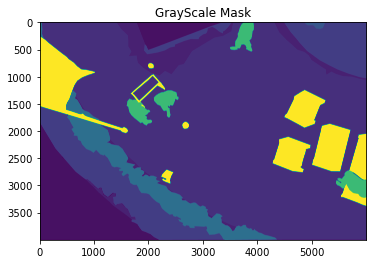

In [38]:
mask = cv2.imread(MASK_PATH + df['id'][100] + '.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)
plt.title("GrayScale Mask")
plt.show()

In [39]:
np.shape(mask)

(4000, 6000)

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [19]:
len(train_loader)

306

In [20]:
len(val_loader)

54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


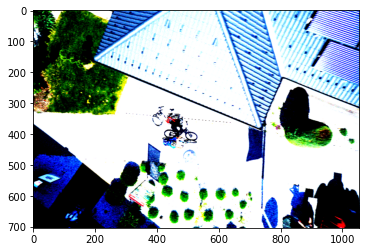

In [45]:
obj_1 = train_set[0]
image = obj_1[0]
image = image.swapaxes(0,1)
image = image.swapaxes(1,2)
plt.imshow(image)
plt.show()

In [46]:
# Loading Model

In [10]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [11]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

In [16]:
!nvidia-smi

Sat Jan 22 07:49:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8    19W /  N/A |    355MiB /  5946MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
!nvidia-smi

Sat Jan 22 07:50:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8    20W /  N/A |   4438MiB /  5946MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
# from torchsummary import summary
# summary(model.cuda(), (1,3,512,718))

In [24]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        # Softmax applied on dimension 1 and then dimension 1 is reduced
        correct = torch.eq(output, mask).int()
        # Performs element wise  equality
        accuracy = float(correct.sum()) / float(correct.numel())
        # Computes Accuracy
    return accuracy

In [25]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [31]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model.state_dict(), 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [32]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.207 
Epoch:1/15.. Train Loss: 1.167.. Val Loss: 1.207.. Train mIoU:0.214.. Val mIoU: 0.195.. Train Acc:0.656.. Val Acc:0.616.. Time: 3.14m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:2/15.. Train Loss: 1.119.. Val Loss: 1.496.. Train mIoU:0.225.. Val mIoU: 0.148.. Train Acc:0.667.. Val Acc:0.527.. Time: 3.11m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Decreasing.. 1.496 >> 1.328 
Epoch:3/15.. Train Loss: 1.165.. Val Loss: 1.328.. Train mIoU:0.212.. Val mIoU: 0.181.. Train Acc:0.656.. Val Acc:0.567.. Time: 3.13m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:4/15.. Train Loss: 1.162.. Val Loss: 1.611.. Train mIoU:0.210.. Val mIoU: 0.159.. Train Acc:0.665.. Val Acc:0.514.. Time: 3.12m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Decreasing.. 1.611 >> 1.454 
Epoch:5/15.. Train Loss: 1.086.. Val Loss: 1.454.. Train mIoU:0.225.. Val mIoU: 0.125.. Train Acc:0.686.. Val Acc:0.516.. Time: 3.08m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Decreasing.. 1.454 >> 1.304 
saving model...
Epoch:6/15.. Train Loss: 0.997.. Val Loss: 1.304.. Train mIoU:0.244.. Val mIoU: 0.184.. Train Acc:0.713.. Val Acc:0.583.. Time: 3.13m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:7/15.. Train Loss: 0.953.. Val Loss: 1.314.. Train mIoU:0.256.. Val mIoU: 0.183.. Train Acc:0.725.. Val Acc:0.580.. Time: 3.09m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Decreasing.. 1.314 >> 1.099 
Epoch:8/15.. Train Loss: 0.867.. Val Loss: 1.099.. Train mIoU:0.275.. Val mIoU: 0.216.. Train Acc:0.750.. Val Acc:0.649.. Time: 3.11m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:9/15.. Train Loss: 0.831.. Val Loss: 1.478.. Train mIoU:0.284.. Val mIoU: 0.181.. Train Acc:0.758.. Val Acc:0.563.. Time: 3.10m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Decreasing.. 1.478 >> 1.125 
Epoch:10/15.. Train Loss: 0.783.. Val Loss: 1.125.. Train mIoU:0.297.. Val mIoU: 0.238.. Train Acc:0.773.. Val Acc:0.643.. Time: 3.10m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Decreasing.. 1.125 >> 1.074 
Epoch:11/15.. Train Loss: 0.730.. Val Loss: 1.074.. Train mIoU:0.311.. Val mIoU: 0.243.. Train Acc:0.786.. Val Acc:0.661.. Time: 3.12m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:12/15.. Train Loss: 0.671.. Val Loss: 1.128.. Train mIoU:0.328.. Val mIoU: 0.227.. Train Acc:0.801.. Val Acc:0.657.. Time: 3.10m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Decreasing.. 1.128 >> 0.998 
Epoch:13/15.. Train Loss: 0.645.. Val Loss: 0.998.. Train mIoU:0.338.. Val mIoU: 0.251.. Train Acc:0.810.. Val Acc:0.687.. Time: 3.10m


  0%|                                                                                                                                                                              | 0/306 [00:00<?, ?it/s]

Loss Decreasing.. 0.998 >> 0.950 
saving model...
Epoch:14/15.. Train Loss: 0.611.. Val Loss: 0.950.. Train mIoU:0.348.. Val mIoU: 0.276.. Train Acc:0.819.. Val Acc:0.699.. Time: 3.15m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.29it/s]

Loss Decreasing.. 0.950 >> 0.845 
Epoch:15/15.. Train Loss: 0.610.. Val Loss: 0.845.. Train mIoU:0.351.. Val mIoU: 0.289.. Train Acc:0.821.. Val Acc:0.738.. Time: 3.14m
Total time: 46.71 m


In [57]:
torch.cuda.empty_cache()

In [58]:
torch.cuda.synchronize()

In [33]:
torch.save(model.state_dict(), "unet_semantic_segmentation.pt")

In [30]:
model.load_state_dict(torch.load("unet_semantic_segmentation.pt"))

<All keys matched successfully>

In [35]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

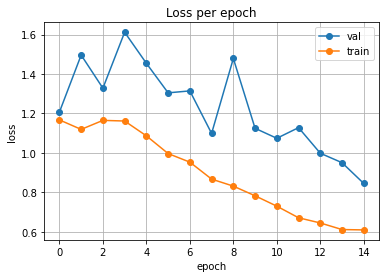

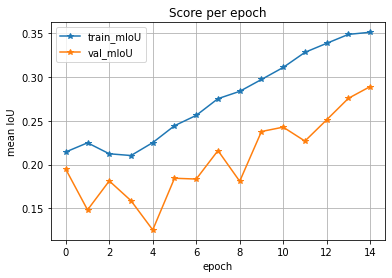

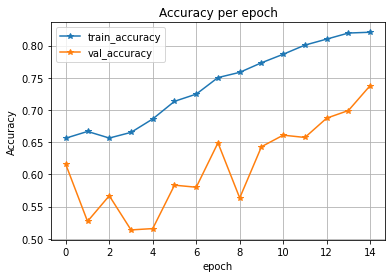

In [36]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [37]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)